In [0]:
import os
os.chdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
os.listdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
# os.mkdir('training_images')

['vgg_face_weights.h5',
 'facenet_weights.h5',
 'inception_resnet_v1.py',
 'training',
 '__pycache__',
 'temp2',
 'known_faces',
 'facenet_BBT.h5',
 'test_images',
 'training_images',
 'test_images (1)',
 'siamese_net_bce.h5',
 'validation_images',
 'siamese_net_con_loss.h5']

In [0]:
!pip install face_recognition

In [0]:
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.initializers import RandomNormal

################
from keras import layers
from keras.layers import Input, Layer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras import backend as K

Using TensorFlow backend.


In [0]:
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def create_model(input_shape):
    X_input = Input(input_shape)

    X = Conv2D(32, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Conv2D(32, (3, 3), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(64, (3, 3), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Conv2D(64, (3, 3), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(128, (3, 3), name = 'conv5', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(256, (1, 1), name = 'conv6', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)
    X = Dropout(0.3)(X)
    
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    
    return Model(inputs=[X_input], outputs=X) 

In [0]:
IMAGE_SIZE = 96
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

convnet = create_model(input_shape)

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1 #1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

In [0]:
siamese_net = Model(inputs=[left_input,right_input],outputs=distance)
optimizer = Adam(0.00006)
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])
# siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
import os
import cv2
import numpy as np
FRAME_THICKNESS = 3
FONT_THICKNESS = 2
TRAINING_FACES_DIR = "training"
faces = os.listdir(TRAINING_FACES_DIR)

def zscore(x):
  mean = np.mean(x)
  std = np.std(x)
  std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
  y = np.multiply(np.subtract(x, mean), 1 / std_adj)
  return y

In [0]:
print("loading faces")

faces = os.listdir(TRAINING_FACES_DIR)
training_images = {}
for name in os.listdir(TRAINING_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{TRAINING_FACES_DIR}/{name}"):
		image = cv2.imread(f"{TRAINING_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	training_images[name] = np.array(temp)

loading faces


In [0]:
# import pickle

# pickle_out = open("/content/drive/My Drive/FACE RECOGNITION TRAINING/training_images/training_images.pickle", "wb")
# pickle.dump(training_images, pickle_out)
# pickle_out.close()

In [0]:
# import pickle 

# pickle_in = open("/content/drive/My Drive/FACE RECOGNITION TRAINING/training_images/training_images.pickle", "rb")
# training_images = pickle.load(pickle_in)


In [0]:
training_images.keys()

dict_keys(['penny', 'howard', 'sheldon', 'raj', 'lenord'])

In [0]:
print("loading validation faces")
VALIDATION_FACES_DIR = "test_images (1)"
validation_faces = os.listdir(VALIDATION_FACES_DIR)
val_images = {}
for name in os.listdir(VALIDATION_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{VALIDATION_FACES_DIR}/{name}"):
		image = cv2.imread(f"{VALIDATION_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	val_images[name] = np.array(temp)

loading validation faces


In [0]:
for name in val_images.keys():
  print(name, len(val_images[name]))

sheldon 18
penny 18
howard 12
lenord 15
raj 14


In [0]:
#Y = 1 if X1 and X2 are deemd similar, and Y = 0 if they are deemed dissimilar
def pairs_generator(batch_size):
    y_val = np.zeros((batch_size, 1))
    positives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    negatives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    while True:
      i = 0
      for i in range(batch_size//2):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace == negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 0

      for i in range(i, batch_size):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace != negativeFace:
              negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 1

        yield ([positives, negatives], y_val)

In [0]:
def validation_set(n = 100):
  for name in faces:
    temp_count[name] = 0


  y_val = np.zeros((n, 1))
  positives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  negatives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  i = 0
  for i in range(n//2):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace == negativeFace:
      negativeFace = faces[np.random.randint(len(faces))]

    temp_count[positiveFace] += 1
    temp_count[negativeFace] += 1

    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 0

  for i in range(i, n):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace != negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

    temp_count[positiveFace] += 1
    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 1

  return ([positives, negatives], y_val)

In [0]:
temp_count = {}
val = validation_set()

In [0]:
for name in faces:
  print (name, temp_count[name])

penny 25
howard 39
sheldon 21
raj 38
lenord 28


In [0]:
# pickle_out2 = open("/content/drive/My Drive/FACE RECOGNITION TRAINING/validation_images/validation_images.pickle", "wb")
# pickle.dump(val, pickle_out2)
# pickle_out2.close()

In [0]:
# pickle_in2 = open("/content/drive/My Drive/FACE RECOGNITION TRAINING/validation_images/validation_images.pickle", "rb")
# val = pickle.load(pickle_in2)

In [0]:
generator = pairs_generator(batch_size=200)
history = siamese_net.fit(generator,
          epochs=50,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/50
50/50 [==============================] - 9s 189ms/step - loss: 1.3966 - accuracy: 0.7650 - val_loss: 0.3209 - val_accuracy: 0.5200
Epoch 2/50
50/50 [==============================] - 7s 142ms/step - loss: 0.3039 - accuracy: 0.6184 - val_loss: 0.4091 - val_accuracy: 0.5100
Epoch 3/50
50/50 [==============================] - 7s 142ms/step - loss: 0.3235 - accuracy: 0.5924 - val_loss: 0.4722 - val_accuracy: 0.5100
Epoch 4/50
50/50 [==============================] - 7s 142ms/step - loss: 0.2905 - accuracy: 0.6418 - val_loss: 0.4391 - val_accuracy: 0.5100
Epoch 5/50
50/50 [==============================] - 7s 142ms/step - loss: 0.2927 - accuracy: 0.6383 - val_loss: 0.4231 - val_accuracy: 0.5100
Epoch 6/50
50/50 [==============================] - 7s 143ms/step - loss: 0.2703 - accuracy: 0.6647 - val_loss: 0.4569 - val_accuracy: 0.5000
Epoch 7/50
50/50 [==============================] - 7s 143ms/step - loss: 0.3062 - accuracy: 0.6288 - val_loss: 0.4638 - val_accuracy: 0.4900
Epoch 

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

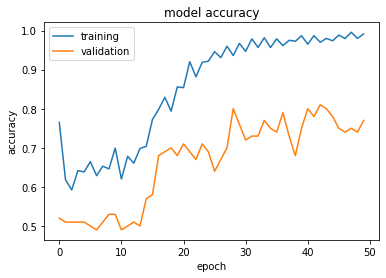

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

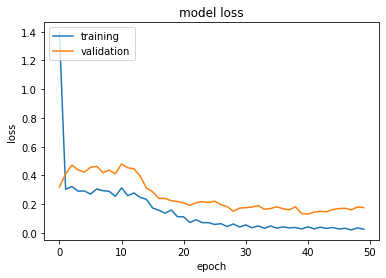

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [0]:
history2 = siamese_net.fit(generator,
          epochs=50,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/50
50/50 [==============================] - 9s 182ms/step - loss: 0.0719 - accuracy: 0.9323 - val_loss: 0.1848 - val_accuracy: 0.7500
Epoch 2/50
50/50 [==============================] - 7s 140ms/step - loss: 0.0540 - accuracy: 0.9550 - val_loss: 0.1964 - val_accuracy: 0.7300
Epoch 3/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0412 - accuracy: 0.9681 - val_loss: 0.1887 - val_accuracy: 0.7300
Epoch 4/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0325 - accuracy: 0.9803 - val_loss: 0.1822 - val_accuracy: 0.7500
Epoch 5/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.1958 - val_accuracy: 0.7600
Epoch 6/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0351 - accuracy: 0.9847 - val_loss: 0.1882 - val_accuracy: 0.7500
Epoch 7/50
50/50 [==============================] - 7s 141ms/step - loss: 0.0299 - accuracy: 0.9879 - val_loss: 0.1828 - val_accuracy: 0.7300
Epoch 

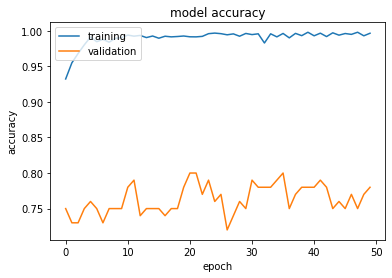

In [0]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

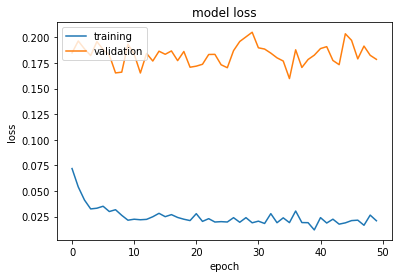

In [0]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [0]:
convnet.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 94, 94, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
bn_conv3 (BatchNormalization (None, 29, 29, 64)        256 

In [0]:
siamese_net.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 256)          427200      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1)            0           model_5[1][0]              

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/siamese_net_con_loss2.h5")

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/training_images/siamese_net_con_loss2.h5")

In [0]:
IMAGE_SIZE

96

In [0]:
import face_recognition
KNOWN_FACES_DIR = "known_faces"
MODEL = "hog" #cnn

print("loading known faces")
known_faces = []
known_names = []

for name in os.listdir(KNOWN_FACES_DIR):
	for filename in os.listdir(f"{KNOWN_FACES_DIR}/{name}"):
		image = face_recognition.load_image_file(f"{KNOWN_FACES_DIR}/{name}/{filename}")
		face_locations = face_recognition.face_locations(image, model=MODEL)
		for top, right, bottom, left in face_locations:
			image = cv2.resize(np.array(image[top:bottom ,left:right]),(IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # cv2.COLOR_RGB2GRAY
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1)
			encoding = convnet.predict(zscore(image))		
		known_faces.append(encoding)
		known_names.append(name)

loading known faces


In [0]:
def testing():
	print('testing')
	positive = 0
	negetive = 0
	test_dir = os.listdir('test_images (1)')
	for name in test_dir:
		test_imgs = os.listdir(f'test_images (1)/{name}')
		for test_img in test_imgs:
			image = cv2.imread(f'test_images (1)/{name}/{test_img}')
			image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # cv2.COLOR_RGB2GRAY
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1) 
			image = zscore(image)
			encoding = convnet.predict(image)
			results = [np.sqrt(np.sum(np.square(known_faces[i]-encoding))) for i in range(len(known_faces))]
			match = known_names[results.index(min(results))]
			if(match == name):
				positive += 1
			else:
				negetive += 1
			print(f'{name}/{test_img}',match, min(results))
	print('accuracy :',positive/(positive+negetive))

In [0]:
testing()

testing
sheldon/2.jpg sheldon 0.04143387
sheldon/10.jpg sheldon 0.045075834
sheldon/9.jpg sheldon 0.06001547
sheldon/5.jpg lenord 0.008928537
sheldon/8.jpg sheldon 0.10145199
sheldon/6.jpg sheldon 0.051815808
sheldon/7.jpg sheldon 0.0048609376
sheldon/4.jpg sheldon 0.004475832
sheldon/1.jpg sheldon 0.07617611
sheldon/111.jpg sheldon 0.013005257
sheldon/668.jpg raj 0.023373842
sheldon/47.jpg sheldon 0.017827272
sheldon/109.jpg sheldon 0.10002339
sheldon/121.jpg raj 0.0017476082
sheldon/161.jpg sheldon 0.013715684
sheldon/124.jpg sheldon 0.05472207
sheldon/126.jpg sheldon 0.016566277
sheldon/127.jpg sheldon 0.004794538
penny/23.jpg sheldon 0.0408414
penny/21.jpg sheldon 0.0016067624
penny/22.jpg raj 0.0018429756
penny/25.jpg sheldon 0.03443271
penny/27.jpg sheldon 0.0091994405
penny/24.jpg penny 0.026329398
penny/26.jpg sheldon 0.06922859
penny/28.jpg sheldon 0.014107585
penny/29.jpg sheldon 0.034373283
penny/30.jpg sheldon 0.044508755
penny/penny.jpg sheldon 0.04603839
penny/755.jpg pen

In [0]:
# https://keras.io/examples/mnist_siamese/
# https://jdhao.github.io/2017/03/13/some_loss_and_explanations/
# https://vitalab.github.io/article/2019/05/15/contrastiveLoss.html